In [6]:
from riskyneuroarousal.modeling.FIRDeconvolution import FIRDeconvolution
import numpy as np
import scipy as sp
import scipy.signal as signal

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# signal parameters
signal_sample_frequency = 1.5
event_1_gain, event_2_gain = 2.3, 0.85
noise_gain = 0.75

# deconvolution parameters
deconv_sample_frequency = 8
deconvolution_interval = [-5, 25]

# how many time points to plot in figures
plot_time = 800

# create some exponentially distributed random ISI events (Dale, 1999) of which we will create and deconvolve responses. 
period_durs = np.random.gamma(4.0,1.5,size = 1000)
events = period_durs.cumsum()
events_1, events_2 = events[0::2], events[1::2]

durations_1, durations_2 = np.random.gamma(2.9,0.75,size = events_1.shape[0]), np.random.gamma(2.9,0.75,size = events_2.shape[0])

# these events are scaled with their own underlying covariate. 
# for instance, you could have a model-based variable that scales the signal on a per-trial basis. 
events_gains_1 = np.random.randn(len(events_1))*0.4
events_gains_2 = np.random.randn(len(events_2))*2.4


# figure parameters
figwidth, figheight = 14, 10


In [ ]:
# events_1 is the start of each of the events

500

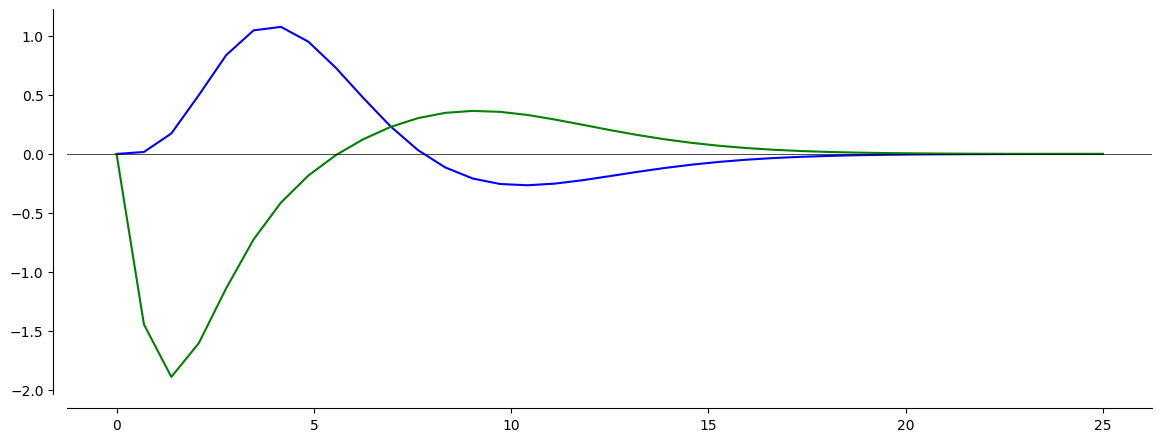

In [7]:
# We create an IRF, using a standard BOLD response and a changed version.

def double_gamma_with_d(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35,d1=5.4,d2=10.8):
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

n_elements = int(25*signal_sample_frequency)

hrf_1 = double_gamma_with_d(np.linspace(0,25,n_elements), a1 = 4.5, a2 = 10, d1 = 5.0, d2 = 10.0)
hrf_2 = -double_gamma_with_d(np.linspace(0,25,n_elements), a1 = 1.5, a2 = 10, d1 = 3.0, d2 = 10.0)
# hrf = hrf/np.abs(hrf).sum()

f = plt.figure(figsize = (figwidth, figheight/2))
plt.plot(np.linspace(0,25,n_elements), hrf_1, 'b')
plt.plot(np.linspace(0,25,n_elements), hrf_2, 'g')
plt.axhline(0, lw=0.5, color = 'k')
sns.despine(offset=10)

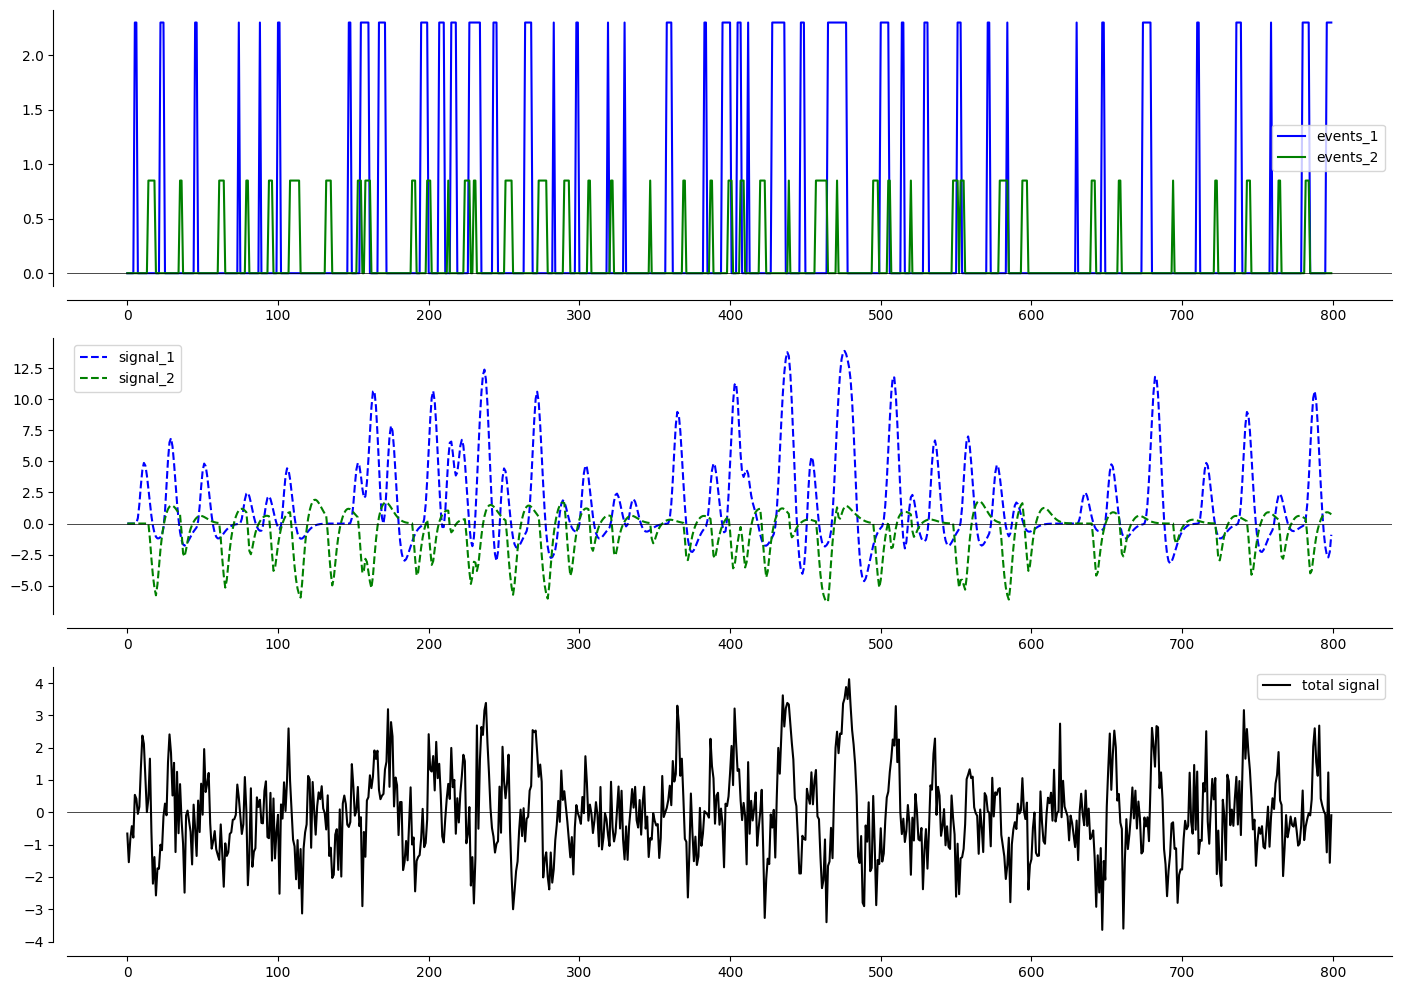

In [9]:
# Using this IRF we're going to create two signals
# signal gains are determined by random covariate and a standard gain
# we mix them all together with some noise, injected on the signal, not the events.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([((times>te) * (times<te+d)) * event_1_gain for te, d in zip(events_1, durations_1)]).sum(axis = 0)
event_2_in_times = np.array([((times>te) * (times<te+d)) * event_2_gain for te, d in zip(events_2, durations_2)]).sum(axis = 0)

signal_1 = signal.fftconvolve(event_1_in_times, hrf_1, 'full')[:times.shape[0]]
signal_2 = signal.fftconvolve(event_2_in_times, hrf_2, 'full')[:times.shape[0]]

# combine the two signals with one another, z-score and add noise
input_data = signal_1 + signal_2
input_data = (input_data - np.mean(input_data)) / input_data.std()
input_data += np.random.randn(input_data.shape[0]) * noise_gain



f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
plt.plot(np.arange(plot_time), event_1_in_times[:plot_time], 'b-')
plt.plot(np.arange(plot_time), event_2_in_times[:plot_time], 'g-')
plt.legend(['events_1', 'events_2',])
sns.despine(offset=10)

plt.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(312)

plt.plot(np.arange(plot_time), signal_1[:plot_time], 'b--')
plt.plot(np.arange(plot_time), signal_2[:plot_time], 'g--')
plt.legend(['signal_1', 'signal_2'])
sns.despine(offset=10)

plt.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(313)

plt.plot(np.arange(plot_time), input_data[:plot_time], 'k-')
plt.legend(['total signal'])
plt.axhline(0, lw=0.5, color = 'k')

sns.despine(offset=10)
plt.tight_layout()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_81386/618420776.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)


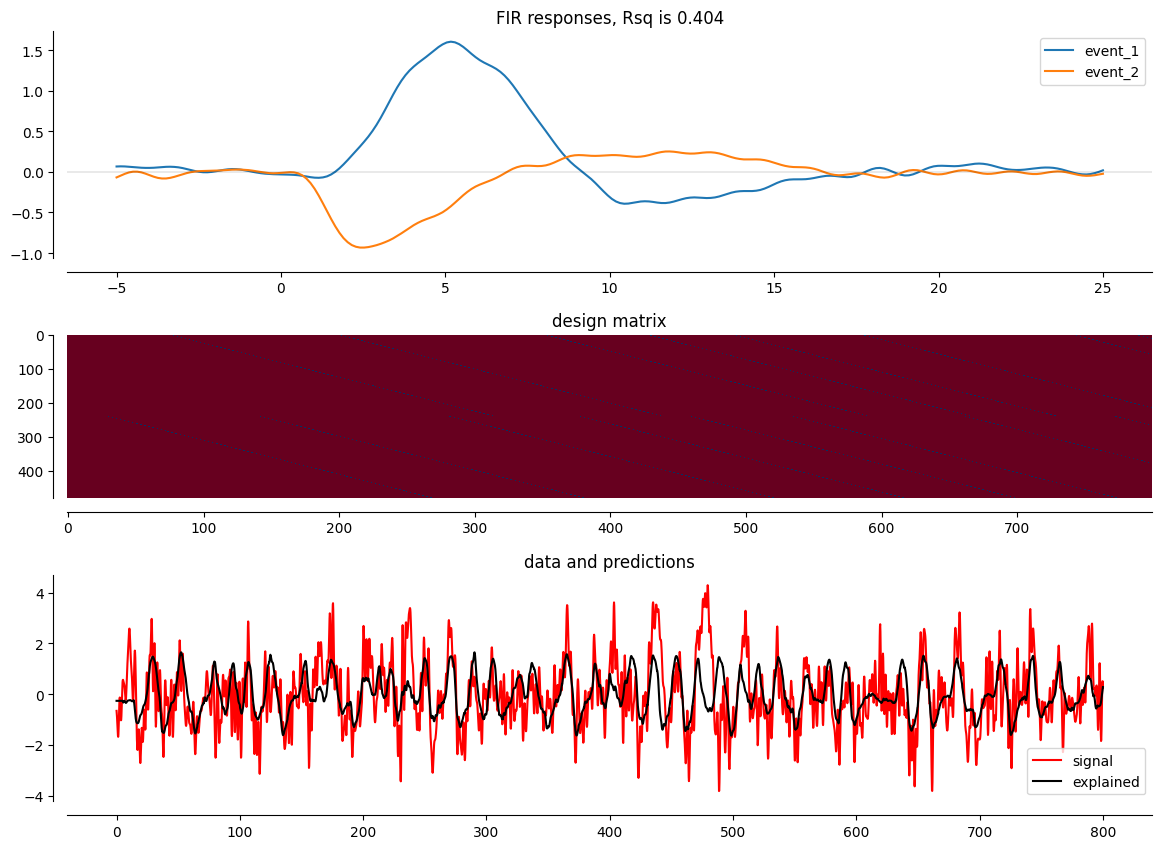

In [10]:
# Up until now, we just created data. 
# Now, we'll use the actual deconvolution package.

# first, we initialize the object
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval
            )

# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression, in this case with the statsmodels backend
fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

fd.calculate_rsq()

# and we see what we've done

f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    plt.plot(fd.deconvolution_interval_timepoints, dec)
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
plt.legend(fd.covariates.keys())
sns.despine(offset=10)

plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sns.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
plt.legend(['signal','explained'])
sns.despine(offset=10)

In [ ]:
durations = {'event_1': durations_1, 'event_2': durations_2}